In [1]:
import numpy as np

def zk(bhw, k, d):
    return pow(1 / (1 - np.exp(-k * bhw)), d)

def dzk(bhw, k, d):
    return -0.5 * k * d * zk(bhw, k, d) * \
                (1 + np.exp(- k * bhw)) / (1 - np.exp(- k * bhw))

def boson_energy(bhw, N, d):
    zs = np.zeros(N + 1)
    dzs = np.zeros(N + 1)
    zs[0] = 1
    dzs[0] = 0
    for m in range(1, N + 1):
        sig_z = 0.0
        sig_dz = 0.0
        for k in range(1, m + 1):
            sig_dz += (1 / m) * (dzk(bhw, k, d) * zs[m - k] + zk(bhw, k, d) * dzs[m - k])
            sig_z += (1 / m) * (zk(bhw, k, d) * zs[m - k])
        zs[m] = sig_z
        dzs[m] = sig_dz
    return (-1 / zs[N] * dzs[N])

def distinguishable_energy(bhw, N, d):
    return boson_energy(bhw, 1, d) * N

def analytical_energy_bhw(num_bosons, bhw, is_distinguishable, dim=3, is_fermions=False):
    N = num_bosons

    if is_fermions:
         return fermion_energy(bhw, N, dim)
    if not is_distinguishable:
         return boson_energy(bhw, N, dim)
    return distinguishable_energy(bhw, N, dim)

def analytical_energy(num_bosons, temperature_kelvin, is_distinguishable, dim=3):
    """Credit: Nentanel Bachar-Schwartz, Jacob Higer"""
    spring_constant = 1.21647924E-8
    mass = 1.0
    omega = np.sqrt(spring_constant / mass)

    # Boltzmann = scipy.constants.Boltzmann
    Boltzmann = 1
    # hbar = scipy.constants.hbar
    hbar = 1

    temperature = temperature_kelvin * 3.1668152e-06 # see units.py of i-pi for conversion to atomic units

    beta = (1 / (Boltzmann * temperature))

    bhw = beta * hbar * omega

    return analytical_energy_bhw(num_bosons, bhw, is_distinguishable, dim=dim, is_fermions=is_fermions) * hbar * omega


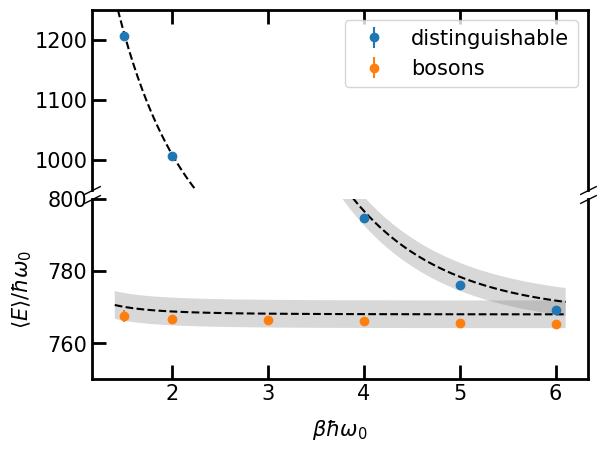

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import re

plt.rcParams['font.size'] = 15
plt.rc('axes',linewidth=2,labelpad=10)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rc('xtick.major',size=10, width=2)
plt.rc('xtick.minor',size=7, width=2)
plt.rc('ytick.major',size=10, width=2)
plt.rc('ytick.minor',size=7, width=2)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

num_bosons = 512

# results
for ptype in ['distinguishable', 'bosons']:
    x = np.loadtxt('data/%s_%s_x' % (num_bosons, ptype))
    y = np.loadtxt('data/%s_%s_y' % (num_bosons, ptype))
    err = np.loadtxt('data/%s_%s_err' % (num_bosons, ptype))
    ax1.errorbar(x, y, err, linestyle='None', marker='o', label='%s' % ptype)
    ax2.errorbar(x, y, err, linestyle='None', marker='o', label='%s' % ptype)

# analytical baseline
for is_distinguishable in [True, False]:
    q = np.linspace(x[0]-0.1, x[-1]+0.1, 100)
    vectorized_analytical_func = np.vectorize(lambda t: analytical_energy_bhw(num_bosons, t, is_distinguishable, dim=3))
    p = vectorized_analytical_func(q)
    ax1.plot(q, p, linestyle='--', color='black')
    ax2.plot(q, p, linestyle='--', color='black')
    #ax2.fill_between(q, p - 0.005 * p, p + 0.005 * p,alpha=0.3, facecolor='grey')
    plt.fill_between(q, p - 0.005 * p, p + 0.005 * p,alpha=0.3, facecolor='grey')


ax1.set_ylim(950, 1250)  # outliers only
ax2.set_ylim(750, 800)  # most of the data


# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.legend()

plt.xlabel(r'$\beta \hbar \omega_0$')
plt.ylabel(r'$\langle E \rangle / \hbar \omega_0$')

plt.savefig('ipi_noninteracting_temperature_512.pdf', bbox_inches='tight')
plt.show()
